# Quantum Mechanics of an Electron in an Electromagnetic Field

In this notebook, we will study the energy levels and wavefunctions of an electron in an electromagnetic field. We make the following simplifying assumptions:

* The problem is two-dimensional and static: the electron moves in the $x$-$y$ plane, and the potentials can vary in $x$ and $y$ but have no $z$ or $t$ dependence.
* The electron is non-relativistic.
* $e = m = \hbar = 1$.

The time-independent Schrödinger wave equation is

$$\left\{\frac{1}{2}\left[\left(-i\frac{\partial}{\partial x} + A_x\right)^2 + \left(-i\frac{\partial}{\partial y} + A_y\right)^2\right] - \Phi(x,y) \right\} \psi(x,y) = E \;\psi(x,y)$$

where:

* $\Phi(x,y)$ is the electromagnetic scalar potential
* $A_x(x,y)$ and $A_y(x,y)$ are the $x$ and $y$ components of the vector potential
* $\psi(x,y)$ is an energy eigenfunction, and $E$ is the corresponding energy

## Numerical solver

A numerical solver for the time-independent Schrödinger equation has been written for you below. The details of how it works are beyond the scope of this discussion, and are not required for the exercises below. (It uses a technique called the [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method), in which space is discretized into a grid, and Taylor expansions are used to convert the partial differential equation into a matrix equation.)

Skim through the code below (**there's no need to read through it in detail**), then run the code cell and move on to the subsequent discussion.

In [1]:
from scipy import *

## Numerical solver for Schrodinger equation for electron in 2D
## See below for detailed documentation and usage examples.
##   Phi, Ax, Ay : functions specifying scalar and vector potential
##   args        : tuple of additional inputs to the potential functions
##   L           : length of computational domain
##   N           : no. of grid points in each direction (x and y)
##   neigs       : no. of solutions to find
##   E0          : approximate energy of solutions to find

def schrodinger2d(Phi, Ax, Ay, args=(), L=1.0, N=50, neigs=30, E0=-100.0):

    from scipy.sparse import diags
    from scipy.sparse.linalg import eigsh

    ## Construct the 2D grid:
    a = L/(N+1)                                # lattice spacing
    p = linspace(-0.5*L+a, 0.5*L-a, N)
    x, y = meshgrid(p, p)
    xx = reshape(x, N*N)                       # 1D array of x
    yy = reshape(y, N*N)                       # 1D array of y

    ## Compute contents of the Hamiltonian matrix:
    Hdiag = 2./a**2 - Phi(xx, yy, *args)       # diagonal terms
    Axvec = Ax(xx+0.5*a, yy, *args)
    offdx = -0.5/a**2 * exp(1j*a*Axvec)        # x-step
    offdx[(N-1)::N] = 0.0; offdx = offdx[:-1]  # Dirichlet BCs in x
    Ayvec = Ay(xx, yy+0.5*a, *args)
    offdy = -0.5/a**2 * exp(1j*a*Ayvec)        # y-step
    offdy = offdy[:-N]                         # Dirichlet BCs in y

    ## Construct the Hamiltonian matrix and solve it:
    H = diags([Hdiag, offdx, conj(offdx), offdy, conj(offdy)],
              [0, 1, -1, N, -N], format='csc', dtype=complex)
    E, psi = eigsh(H, neigs, sigma=E0, return_eigenvectors=True)
    idx = argsort(E); E = E[idx]; psi = psi[:,idx]  # sort in increasing E
    psi = reshape(psi, (N, N, neigs))
    return E, psi, x, y

### Inputs and outputs of the `schrodinger2d` function

The inputs to the `schrodinger2d` function that you need to be concerned with are `Phi`, `Ax`, `Ay`, and `args`.

For `Phi`, `Ax`, and `Ay`, the caller must supply *helper functions* to specify the scalar and vector potentials. For `args`, the caller supplies a tuple of additional parameters, to be passed to these helper functions; if no additional parameters are needed, omit this input.

Each helper function must accept inputs `(x, y, ...)`, where `x` and `y` are arrays specifying the $x$ and $y$ coordinates  at which to compute the potential, and the other inputs, denoted by `...`, are the additional parameters given in `args`. The helper function must return an array giving the potential at the specified positions.

The other inputs to `schrodinger2d` may be omitted (i.e., left to their default values). These defaults specify a square computational cell of length `L=1.0`, with `N=50` grid points in each direction. The coordinate origin, $x = y = 0$, is the center of the box, and Dirichlet boundary conditions are imposed at the walls of the box. The solver finds the `neigs=30` solutions whose energy eigenvalues are closest to `E0=-100.0`.

The `schrodinger2d` function returns three values:

* `E` is an array of energy eigenvalues located by the numerical solver, sorted in increasing order.
* `psi` is an array containing the corresponding wavefunctions, such that `psi[:,:,n]` is a 2D array specifying the grid values of the `n`-th wavefunction.
* `x` and `y` are 2D arrays specifying the $x$ and $y$ grid coordinates.

## Example 1: uniform magnetic field and quadratic scalar potential

Let us work through an example. Consider these potentials:

$$\begin{aligned} \Phi &= - V_0 (x^2 + y^2) \\ A_x &= - B_0 y \\ A_y &= 0. \end{aligned}$$

For $V_0 > 0$, the scalar potential sets up a quadratic potential well centered at the origin (since the electron is negatively charged, more negative $\Phi$ corresponds to higher potential energy). The vector potential generates a uniform "out-of-plane" magnetic field $\vec{B} = [0, 0, B_0]$ (you can verify this by calculating the curl of $\vec{A}$).

To use the numerical solver, we define Python functions corresponding to these potentials:

In [2]:
def Phi_ex1(x, y, V0, B0):
    return - V0 * (x*x + y*y)

def Ax_ex1(x, y, V0, B0):
    return - B0 * y

def Ay_ex1(x, y, V0, B0):
    return zeros(x.shape)   #  Array of all zeros, with same shape as x.

Then we can choose some values for $V_0$ and $B_0$, call `schrodinger2d`, and plot the results:

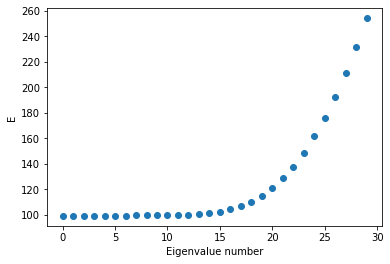

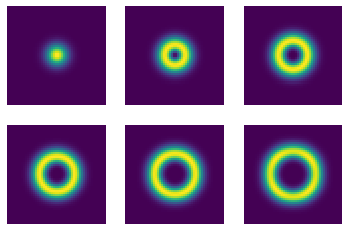

In [3]:
import matplotlib.pyplot as plt

V0, B0 = 5.0, 200.0 # V0 and B0
E, psi, x, y = schrodinger2d(Phi_ex1, Ax_ex1, Ay_ex1, (V0, B0))

## Plot the energy levels
plt.figure(1)
plt.plot(E, 'o')
plt.xlabel('Eigenvalue number'); plt.ylabel('E')

## Plot |psi|^2 for lowest 4 eigenstates
plt.figure(2)
for n in range(6):
    plt.subplot(2, 3, n+1)
    plt.pcolor(x, y, abs(psi[:,:,n])**2)  # Plot heat map
    plt.axis("equal"); plt.axis("off")

The upper plot shows the energy spectrum. Notice that there are lots of eigenstates with energy $E \simeq 100$. This is called a [Landau level](https://en.wikipedia.org/wiki/Landau_quantization); the energy of this Landau level is $\hbar e B_0 /2m = 100$ (since $B_0 = 200$ and $\hbar = e = m = 1$). The lower plot shows heat maps of the probability density $|\psi|^2$ in the $x$-$y$ plane, for the six lowest energy eigenstates. We see that the eigenfunctions form rings analogous to the classical circular orbit of a charged particle in a magnetic field.

## Task 1: Demonstrate Gauge Invariance (10 marks)

Consider the gauge field

$$\lambda(x,y) = ax + by,$$

where $a$ and $b$ are arbitrary constants. Amend the above scalar and vector potential functions to include the contributions from this gauge field. Then write code to demonstrate that the system has the same energy eigenvalues and probability densities for various different choices of $a$ and $b$.

It is up to you to choose exactly what plots to generate to demonstrate this phenomenon.

In [4]:
def Phi_task1(x, y, V0, B0, a, b):
    return zeros(x.shape) # FIXME

def Ax_task1(x, y, V0, B0, a, b):
    return zeros(x.shape) # FIXME

def Ay_task1(x, y, V0, B0, a, b):
    return zeros(x.shape) # FIXME

## TO DO: GENERATE PLOTS TO DEMONSTRATE GAUGE INVARIANCE...

## Task 2: Threading a magnetic flux (10 marks)

Consider the following scalar potential:

$$\Phi = V_0 \left\{\exp\left[-\frac{(r-R_0)^2}{2d^2}\right] - 1\right\}$$

where $r = \sqrt{x^2+y^2}$. This scalar potential generates a ring of radius $R_0$, as shown in the plot below. For $V_0 > 0$, the potential tends to push the wavefunctions onto the ring, away from the origin.

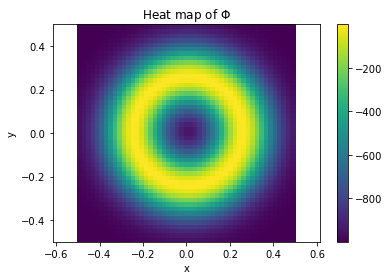

In [5]:
def Phi_task2(x, y, V0, R0, d, PhiB):
    r = sqrt(x**2 + y**2)
    return V0 * (exp(-0.5 * (r-R0)**2 / d**2) - 1.0)    # PhiB is not used here; see below.

## Plot Phi for a particular choice of parameters:
V0, R0, d, PhiB = 1000, 0.25, 0.1, 0.
xa = linspace(-0.5, 0.5, 50); x, y = meshgrid(xa, xa)
Phi = Phi_task2(x, y, V0, R0, d, PhiB)

plt.pcolor(x, y, Phi)
plt.axis("equal")
plt.title("Heat map of $\Phi$")
plt.xlabel("x"); plt.ylabel("y")
plt.colorbar()
plt.show()

Take the following vector potential:

$$\begin{aligned} A_x &= - \frac{\Phi_B}{2\pi r} \sin\phi \\ A_y &= \;\;\frac{\Phi_B}{2\pi r} \cos\phi. \end{aligned}$$

Here, $\phi$ is the usual azimuthal coordinate (which can be computed from $x$ and $y$ using the [`arctan2`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arctan2.html) function). This vector potential corresponds to an infinitesimally narrow spike of magnetic flux $\Phi_B$ at the coordinate origin. As previously discussed (see the course notes), at every other position the the magnetic field is zero yet the vector potential is nonzero.

Write code to generate a plot showing how the energy spectrum varies with $\Phi_B$. Hence, demonstrate that (i) the spectrum varies with $\Phi_B$, and (ii) the spectrum returns to itself whenever $\Phi_B$ varies by $h/e$ (in the present computational units, $h/e = 2\pi$ ).

In [6]:
def Ax_task2(x, y, V0, R0, d, PhiB):
    phi = arctan2(y, x)   # azimuthal coordinate
    return zeros(x.shape) # FIXME

def Ay_task2(x, y, V0, R0, d, PhiB):
    return zeros(x.shape) # FIXME

## TO DO: GENERATE PLOT OF ENERGY VERSUS PhiB...
